In [28]:
import glob
import skimage
import scipy
import json
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from tqdm import tqdm
%matplotlib inline
sys.path.insert(0, "/home/mengdi/yuxiang.ye/ai-eyes-care/nodule_detect/lib")
from Dcm_Series import Series
from helper import normalize_hu
lidc_path = "/home/mengdi/DataShare/LIDC/LIDC-IDRI/DOI/*"
lidc_info = "/home/mengdi/yuxiang.ye/DN_AI_frame/workspace/lidc/LIDC_INFO.csv"

In [2]:
lidc_files = sorted(glob.glob(lidc_path))

In [3]:
lidc_info_df = pd.read_csv(lidc_info)
lidc_info_large_df = lidc_info_df.loc[lidc_info_df.parse_type == "large_nodule"]

In [4]:
lidc_info_large_df.shape

(6795, 16)

In [33]:
def plot_seg(arr,  ds, spacing_xyz, origin_xyz, seg_xml_list):
    '''seg_xml get from lidc xml'''
    shape = arr.shape
    seg_zero = np.zeros(shape)
    for seg_xml in tqdm(seg_xml_list):
        for z_seg_xml in eval(seg_xml):
            # z, get z coords
            coordz = int(abs(z_seg_xml['imageZposition'] - ds.Dcm_series_origin[-1]) / ds.Dcm_series_spacing[-1])
            coordxy = np.array(z_seg_xml['coords'])
#             coordxy_path = Path(coordxy)
            for x,y in coordxy:
                seg_zero[coordz, y, x] =True
            # 1.convex_hull_object
#             seg_zero[coordz] = np.maximum(skimage.morphology.convex_hull_object(seg_zero[coordz]), seg_zero[coordz])
            # 2. binary_fill_holes
            seg_zero[coordz] = np.maximum(scipy.ndimage.binary_fill_holes(seg_zero[coordz]), seg_zero[coordz])
#             for x in range(shape[2]):
#                 for y in range(shape[1]):
#                     seg_zero[coordz, y , x] = coordxy_path.contains_point((x,y))
    return seg_zero.astype(np.bool)

In [34]:
class PathParser:
    def __init__(self, folder):
        self.folder = folder
        root_list = []
        file_len_list = []
        for root, dirname, files in os.walk(self.folder):
            root_list.append(root)
            file_len_list.append(len(files))    
        self.lidcpath = max(zip(file_len_list, root_list))[1]

In [35]:
lidc_files[0]

'/home/mengdi/DataShare/LIDC/LIDC-IDRI/DOI/LIDC-IDRI-0001'

In [36]:
lidc_name = "LIDC-IDRI-0942"
ds = Series([PathParser("/home/mengdi/DataShare/LIDC/LIDC-IDRI/DOI/%s" % lidc_name).lidcpath], None)
lidc0 = ds.Dcm_series_arr
lidc0_norm = (normalize_hu(ds.Dcm_series_arr) * 255).astype(np.uint8)

lidc0_seg_xml = lidc_info_large_df.loc[lidc_info_large_df.seriesuid == "LIDC-IDRI-0942", 'rois'].values

In [37]:
seg = plot_seg(ds.Dcm_series_arr, ds, ds.Dcm_series_spacing, ds.Dcm_series_origin, lidc0_seg_xml)

100%|██████████| 14/14 [00:01<00:00,  7.45it/s]


In [38]:
np.argmax(np.sum(seg, axis=(1,2)))

153

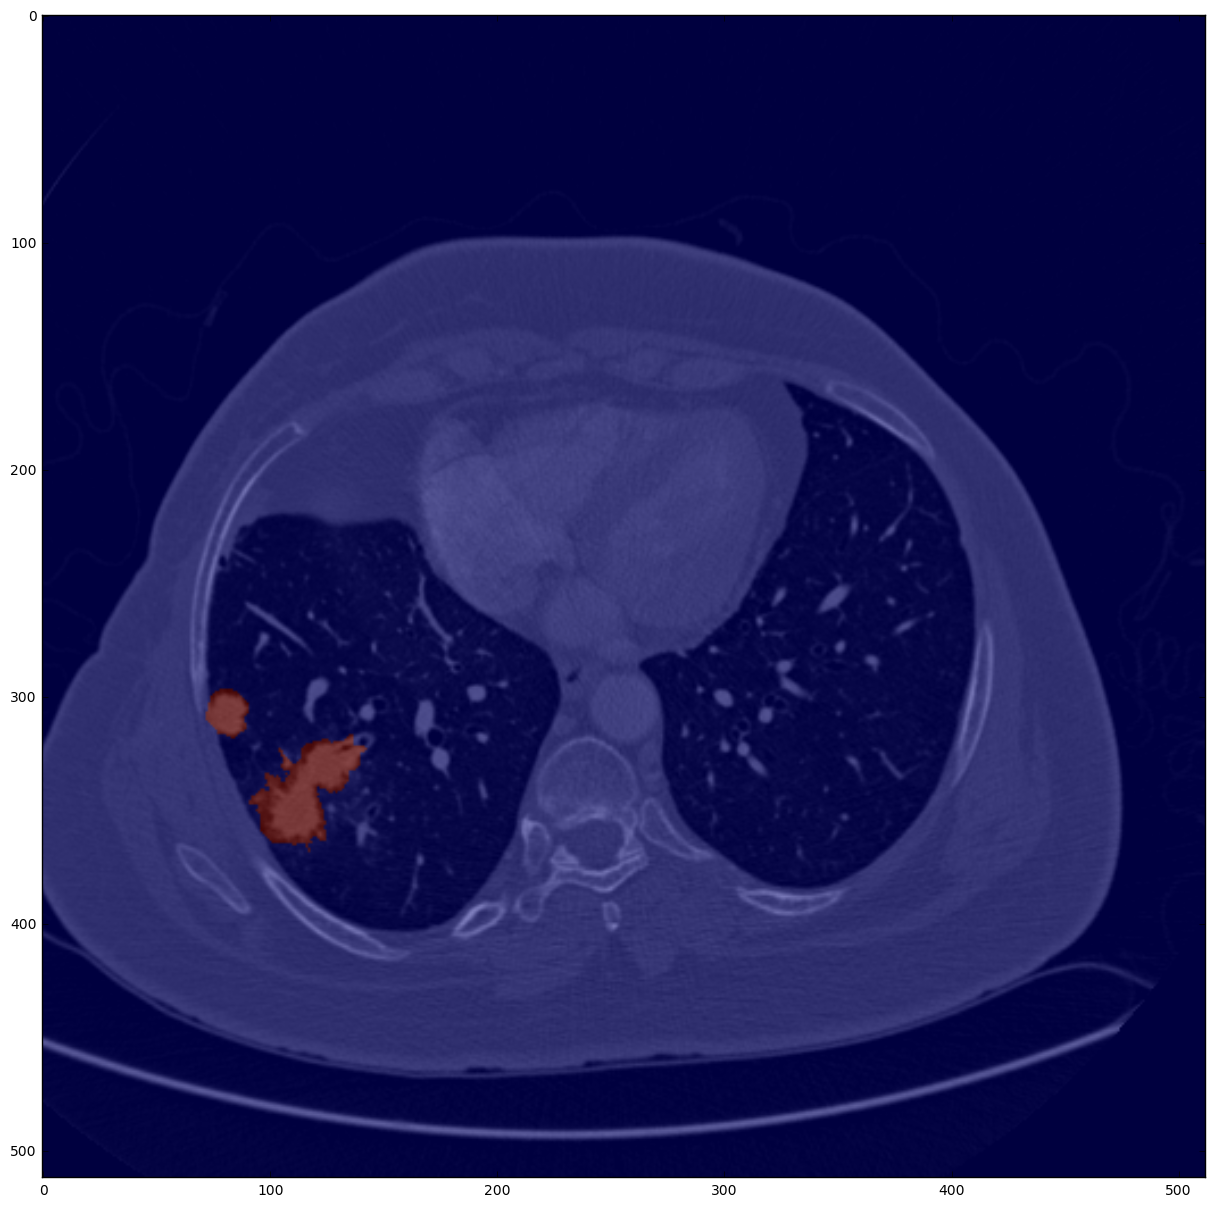

In [39]:
index = 153
plt.figure(figsize=(15,15))
plt.imshow(ds.Dcm_series_arr[index],plt.cm.gray)
plt.imshow(seg[index],alpha=0.5)
# plt.imshow(seg1_148_new, alpha=0.5)

# crete npz  include arr and seg

In [40]:
path = "/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new"

In [41]:
def plot_voxel_save(path, arr, aux, title):
    assert arr.shape == aux.shape
    max_index = np.argmax(np.sum(aux, axis=(1,2)))
    plt.clf()
    _, axes = plt.subplots(1,2)
    axes[0].imshow(arr[max_index], cmap=plt.cm.gray)
    axes[0].imshow(aux[max_index], alpha=0.2)
    axes[0].set_title(str(max_index))
    axes[1].plot(np.sum(aux, axis=(1,2)))
    axes[1].set_title(title)
    plt.savefig(path)

In [45]:
def task(lidc_f):
    seriesuid = os.path.basename(lidc_f)
    target_path = os.path.join(path, seriesuid + ".npz")
    png_path = os.path.join(path, seriesuid + ".png")
    print(target_path)
    if os.path.exists(target_path):
        return
    print(seriesuid)
    lidcpath = PathParser(lidc_f).lidcpath
    ds = Series([lidcpath], None)
    lidc0_seg_xml = lidc_info_large_df.loc[lidc_info_large_df.seriesuid == seriesuid, 'rois'].values
    arr = ds.Dcm_series_arr
    space = ds.Dcm_series_spacing
    origin = ds.Dcm_series_origin
    seg = plot_seg(arr, ds, space, origin, lidc0_seg_xml)
    np.savez_compressed(target_path, raw = arr, seg=seg)
    plot_voxel_save(png_path, normalize_hu(arr), seg, seriesuid)
    return seg, arr

In [ ]:
for arg in lidc_files:
    task(arg)

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0001.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0002.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0003.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0004.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0005.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0006.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0007.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0008.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0009.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0010.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0011.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0012.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/data

100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0023.npz
LIDC-IDRI-0023


100%|██████████| 4/4 [00:00<00:00,  8.43it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0024.npz
LIDC-IDRI-0024


100%|██████████| 12/12 [00:00<00:00, 25.18it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0025.npz
LIDC-IDRI-0025


100%|██████████| 1/1 [00:00<00:00, 24.06it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0026.npz
LIDC-IDRI-0026


100%|██████████| 3/3 [00:00<00:00, 42.73it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0027.npz
LIDC-IDRI-0027


100%|██████████| 19/19 [00:00<00:00, 28.96it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0028.npz
LIDC-IDRI-0028


0it [00:00, ?it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0029.npz
LIDC-IDRI-0029


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0030.npz
LIDC-IDRI-0030


100%|██████████| 4/4 [00:00<00:00, 35.61it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0031.npz
LIDC-IDRI-0031


100%|██████████| 14/14 [00:00<00:00, 22.78it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0032.npz
LIDC-IDRI-0032


0it [00:00, ?it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0033.npz
LIDC-IDRI-0033


100%|██████████| 5/5 [00:00<00:00, 26.97it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0034.npz
LIDC-IDRI-0034


100%|██████████| 3/3 [00:00<00:00, 27.07it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0035.npz
LIDC-IDRI-0035


100%|██████████| 2/2 [00:00<00:00, 40.85it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0036.npz
LIDC-IDRI-0036


100%|██████████| 5/5 [00:00<00:00, 16.44it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0037.npz
LIDC-IDRI-0037


100%|██████████| 7/7 [00:00<00:00, 21.51it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0038.npz
LIDC-IDRI-0038


100%|██████████| 1/1 [00:00<00:00, 48.62it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0039.npz
LIDC-IDRI-0039


100%|██████████| 20/20 [00:00<00:00, 19.46it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0040.npz
LIDC-IDRI-0040


100%|██████████| 7/7 [00:00<00:00, 46.46it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0041.npz
LIDC-IDRI-0041


100%|██████████| 7/7 [00:00<00:00, 19.32it/s]
/home/mengdi/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0042.npz
LIDC-IDRI-0042


100%|██████████| 22/22 [00:00<00:00, 44.21it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0043.npz
LIDC-IDRI-0043


100%|██████████| 10/10 [00:00<00:00, 20.61it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0044.npz
LIDC-IDRI-0044


100%|██████████| 13/13 [00:00<00:00, 14.55it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0045.npz
LIDC-IDRI-0045


100%|██████████| 33/33 [00:01<00:00, 26.94it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0046.npz
LIDC-IDRI-0046


100%|██████████| 21/21 [00:00<00:00, 34.80it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0047.npz
LIDC-IDRI-0047


100%|██████████| 4/4 [00:00<00:00, 23.32it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0048.npz
LIDC-IDRI-0048


100%|██████████| 7/7 [00:00<00:00, 19.89it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0049.npz
LIDC-IDRI-0049


100%|██████████| 39/39 [00:00<00:00, 41.11it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0050.npz
LIDC-IDRI-0050


100%|██████████| 4/4 [00:00<00:00, 11.37it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0051.npz
LIDC-IDRI-0051


100%|██████████| 9/9 [00:00<00:00, 19.28it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0052.npz
LIDC-IDRI-0052


100%|██████████| 8/8 [00:01<00:00,  7.81it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0053.npz
LIDC-IDRI-0053


100%|██████████| 8/8 [00:00<00:00, 15.53it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0054.npz
LIDC-IDRI-0054


100%|██████████| 4/4 [00:00<00:00, 16.27it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0055.npz
LIDC-IDRI-0055


100%|██████████| 20/20 [00:00<00:00, 34.12it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0056.npz
LIDC-IDRI-0056


100%|██████████| 10/10 [00:00<00:00, 20.23it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0057.npz
LIDC-IDRI-0057


100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0058.npz
LIDC-IDRI-0058


100%|██████████| 9/9 [00:00<00:00, 13.71it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0059.npz
LIDC-IDRI-0059


100%|██████████| 4/4 [00:00<00:00, 24.84it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0060.npz
LIDC-IDRI-0060


100%|██████████| 13/13 [00:00<00:00, 16.72it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0061.npz
LIDC-IDRI-0061


100%|██████████| 19/19 [00:01<00:00, 11.55it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0062.npz
LIDC-IDRI-0062


0it [00:00, ?it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0063.npz
LIDC-IDRI-0063


100%|██████████| 10/10 [00:00<00:00, 25.50it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0064.npz
LIDC-IDRI-0064


100%|██████████| 8/8 [00:00<00:00,  9.83it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0065.npz
LIDC-IDRI-0065


100%|██████████| 2/2 [00:00<00:00, 50.49it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0066.npz
LIDC-IDRI-0066


100%|██████████| 11/11 [00:02<00:00,  5.48it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0067.npz
LIDC-IDRI-0067


100%|██████████| 14/14 [00:00<00:00, 18.82it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0068.npz
LIDC-IDRI-0068


100%|██████████| 22/22 [00:01<00:00, 16.60it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0069.npz
LIDC-IDRI-0069


100%|██████████| 9/9 [00:00<00:00, 14.95it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0070.npz
LIDC-IDRI-0070


100%|██████████| 7/7 [00:00<00:00, 61.56it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0071.npz
LIDC-IDRI-0071


0it [00:00, ?it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0072.npz
LIDC-IDRI-0072


100%|██████████| 3/3 [00:00<00:00,  3.85it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0073.npz
LIDC-IDRI-0073


100%|██████████| 7/7 [00:00<00:00, 25.25it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0074.npz
LIDC-IDRI-0074


100%|██████████| 3/3 [00:00<00:00, 14.73it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0075.npz
LIDC-IDRI-0075


100%|██████████| 9/9 [00:00<00:00,  9.50it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0076.npz
LIDC-IDRI-0076


100%|██████████| 8/8 [00:00<00:00, 16.61it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0077.npz
LIDC-IDRI-0077


100%|██████████| 5/5 [00:00<00:00,  9.86it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0078.npz
LIDC-IDRI-0078


100%|██████████| 13/13 [00:00<00:00, 16.39it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0079.npz
LIDC-IDRI-0079


100%|██████████| 4/4 [00:00<00:00, 22.58it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0080.npz
LIDC-IDRI-0080


100%|██████████| 7/7 [00:00<00:00,  7.13it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0081.npz
LIDC-IDRI-0081


100%|██████████| 7/7 [00:00<00:00, 15.65it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0082.npz
LIDC-IDRI-0082


100%|██████████| 3/3 [00:00<00:00,  7.33it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0083.npz
LIDC-IDRI-0083


100%|██████████| 7/7 [00:00<00:00, 28.79it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0084.npz
LIDC-IDRI-0084


100%|██████████| 13/13 [00:00<00:00, 37.25it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0085.npz
LIDC-IDRI-0085


100%|██████████| 5/5 [00:00<00:00, 49.39it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0086.npz
LIDC-IDRI-0086


100%|██████████| 2/2 [00:00<00:00, 18.24it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0087.npz
LIDC-IDRI-0087


100%|██████████| 4/4 [00:00<00:00,  9.68it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0088.npz
LIDC-IDRI-0088


100%|██████████| 10/10 [00:00<00:00, 29.80it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0089.npz
LIDC-IDRI-0089


100%|██████████| 4/4 [00:00<00:00,  9.43it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0090.npz
LIDC-IDRI-0090


100%|██████████| 4/4 [00:00<00:00, 35.46it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0091.npz
LIDC-IDRI-0091


100%|██████████| 17/17 [00:01<00:00, 15.58it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0092.npz
LIDC-IDRI-0092


100%|██████████| 13/13 [00:00<00:00, 18.06it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0093.npz
LIDC-IDRI-0093


100%|██████████| 5/5 [00:00<00:00, 34.67it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0094.npz
LIDC-IDRI-0094


100%|██████████| 4/4 [00:01<00:00,  3.70it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0095.npz
LIDC-IDRI-0095


100%|██████████| 9/9 [00:01<00:00,  8.27it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0096.npz
LIDC-IDRI-0096


100%|██████████| 3/3 [00:00<00:00, 37.62it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0097.npz
LIDC-IDRI-0097


100%|██████████| 3/3 [00:00<00:00, 17.26it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0098.npz
LIDC-IDRI-0098


100%|██████████| 3/3 [00:00<00:00, 23.69it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0099.npz
LIDC-IDRI-0099


100%|██████████| 9/9 [00:00<00:00, 20.13it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0100.npz
LIDC-IDRI-0100


0it [00:00, ?it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0101.npz
LIDC-IDRI-0101


100%|██████████| 2/2 [00:00<00:00, 46.38it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0102.npz
LIDC-IDRI-0102


100%|██████████| 3/3 [00:00<00:00, 60.53it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0103.npz
LIDC-IDRI-0103


100%|██████████| 5/5 [00:00<00:00, 53.89it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0104.npz
LIDC-IDRI-0104


100%|██████████| 4/4 [00:00<00:00, 19.73it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0105.npz
LIDC-IDRI-0105


100%|██████████| 3/3 [00:00<00:00, 41.96it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0106.npz
LIDC-IDRI-0106


100%|██████████| 10/10 [00:00<00:00, 33.95it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0107.npz
LIDC-IDRI-0107


100%|██████████| 6/6 [00:00<00:00, 30.40it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0108.npz
LIDC-IDRI-0108


100%|██████████| 6/6 [00:00<00:00, 18.02it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0109.npz
LIDC-IDRI-0109


100%|██████████| 4/4 [00:00<00:00, 12.17it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0110.npz
LIDC-IDRI-0110


100%|██████████| 6/6 [00:00<00:00, 39.79it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0111.npz
LIDC-IDRI-0111


100%|██████████| 18/18 [00:00<00:00, 20.84it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0112.npz
LIDC-IDRI-0112


100%|██████████| 4/4 [00:00<00:00, 25.03it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0113.npz
LIDC-IDRI-0113


100%|██████████| 3/3 [00:00<00:00, 36.92it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0114.npz
LIDC-IDRI-0114


100%|██████████| 4/4 [00:00<00:00, 12.56it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0115.npz
LIDC-IDRI-0115


100%|██████████| 4/4 [00:00<00:00, 11.95it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0116.npz
LIDC-IDRI-0116


100%|██████████| 5/5 [00:00<00:00, 17.61it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0117.npz
LIDC-IDRI-0117


100%|██████████| 4/4 [00:00<00:00, 23.35it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0118.npz
LIDC-IDRI-0118


100%|██████████| 16/16 [00:00<00:00, 23.38it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0119.npz
LIDC-IDRI-0119


100%|██████████| 8/8 [00:00<00:00,  9.03it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0120.npz
LIDC-IDRI-0120


100%|██████████| 10/10 [00:00<00:00, 13.90it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0121.npz
LIDC-IDRI-0121


100%|██████████| 8/8 [00:00<00:00, 11.47it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0122.npz
LIDC-IDRI-0122


100%|██████████| 4/4 [00:00<00:00, 31.50it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0123.npz
LIDC-IDRI-0123


100%|██████████| 2/2 [00:00<00:00, 20.12it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0124.npz
LIDC-IDRI-0124


100%|██████████| 35/35 [00:00<00:00, 37.47it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0125.npz
LIDC-IDRI-0125


100%|██████████| 5/5 [00:00<00:00, 31.66it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0126.npz
LIDC-IDRI-0126


100%|██████████| 7/7 [00:00<00:00, 36.26it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0127.npz
LIDC-IDRI-0127


100%|██████████| 2/2 [00:00<00:00,  6.76it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0128.npz
LIDC-IDRI-0128


100%|██████████| 8/8 [00:00<00:00, 18.76it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0129.npz
LIDC-IDRI-0129


100%|██████████| 48/48 [00:02<00:00, 18.65it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0130.npz
LIDC-IDRI-0130


100%|██████████| 8/8 [00:00<00:00, 10.15it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0131.npz
LIDC-IDRI-0131


100%|██████████| 4/4 [00:00<00:00, 25.59it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0132.npz
LIDC-IDRI-0132


100%|██████████| 12/12 [00:00<00:00, 26.68it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0133.npz
LIDC-IDRI-0133


100%|██████████| 7/7 [00:00<00:00,  8.78it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0134.npz
LIDC-IDRI-0134


100%|██████████| 9/9 [00:00<00:00, 27.47it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0135.npz
LIDC-IDRI-0135


100%|██████████| 19/19 [00:00<00:00, 37.55it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0136.npz
LIDC-IDRI-0136


100%|██████████| 21/21 [00:00<00:00, 38.57it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0137.npz
LIDC-IDRI-0137


100%|██████████| 10/10 [00:00<00:00, 16.52it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0138.npz
LIDC-IDRI-0138


100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0139.npz
LIDC-IDRI-0139


100%|██████████| 9/9 [00:00<00:00, 10.14it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0140.npz
LIDC-IDRI-0140


100%|██████████| 4/4 [00:00<00:00,  5.92it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0141.npz
LIDC-IDRI-0141


100%|██████████| 16/16 [00:02<00:00,  6.74it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0142.npz
LIDC-IDRI-0142


100%|██████████| 13/13 [00:00<00:00, 14.85it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0143.npz
LIDC-IDRI-0143


0it [00:00, ?it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0144.npz
LIDC-IDRI-0144


100%|██████████| 17/17 [00:00<00:00, 26.92it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0145.npz
LIDC-IDRI-0145


100%|██████████| 6/6 [00:00<00:00, 31.55it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0146.npz
LIDC-IDRI-0146


100%|██████████| 4/4 [00:00<00:00,  6.34it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0147.npz
LIDC-IDRI-0147


100%|██████████| 15/15 [00:00<00:00, 34.81it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0148.npz
LIDC-IDRI-0148


100%|██████████| 9/9 [00:00<00:00, 18.11it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0149.npz
LIDC-IDRI-0149


100%|██████████| 16/16 [00:00<00:00, 42.70it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0150.npz
LIDC-IDRI-0150


100%|██████████| 4/4 [00:00<00:00, 22.47it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0151.npz
LIDC-IDRI-0151


100%|██████████| 4/4 [00:00<00:00, 23.16it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0152.npz
LIDC-IDRI-0152


100%|██████████| 4/4 [00:00<00:00, 25.11it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0153.npz
LIDC-IDRI-0153


100%|██████████| 6/6 [00:00<00:00, 14.53it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0154.npz
LIDC-IDRI-0154


100%|██████████| 5/5 [00:00<00:00, 14.15it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0155.npz
LIDC-IDRI-0155


100%|██████████| 2/2 [00:00<00:00, 28.21it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0156.npz
LIDC-IDRI-0156


100%|██████████| 4/4 [00:00<00:00, 23.91it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0157.npz
LIDC-IDRI-0157


100%|██████████| 2/2 [00:00<00:00, 48.41it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0158.npz
LIDC-IDRI-0158


100%|██████████| 10/10 [00:00<00:00, 14.32it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0159.npz
LIDC-IDRI-0159


100%|██████████| 6/6 [00:00<00:00, 21.04it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0160.npz
LIDC-IDRI-0160


100%|██████████| 15/15 [00:00<00:00, 23.61it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0161.npz
LIDC-IDRI-0161


100%|██████████| 10/10 [00:00<00:00, 19.57it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0162.npz
LIDC-IDRI-0162


100%|██████████| 5/5 [00:00<00:00, 31.08it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0163.npz
LIDC-IDRI-0163


100%|██████████| 4/4 [00:00<00:00,  9.49it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0164.npz
LIDC-IDRI-0164


100%|██████████| 36/36 [00:02<00:00, 15.53it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0165.npz
LIDC-IDRI-0165


100%|██████████| 1/1 [00:00<00:00, 46.99it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0166.npz
LIDC-IDRI-0166


100%|██████████| 2/2 [00:00<00:00,  6.14it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0167.npz
LIDC-IDRI-0167


100%|██████████| 6/6 [00:00<00:00, 41.55it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg_new/LIDC-IDRI-0168.npz
LIDC-IDRI-0168


In [10]:
from concurrent.futures import as_completed, ProcessPoolExecutor

In [11]:
from tqdm import tqdm
with ProcessPoolExecutor(max_workers=2) as executor:
    futures = {executor.submit(task, arg) for arg in lidc_files}
    try:
        for f in tqdm(as_completed(futures),total=len(lidc_files)):
            err = f.exception()
            if err is not None:
               raise err
    except KeyboardInterrupt:
        print("stopped by hand")    

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0002.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0013.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0003.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0004.npz


  0%|          | 0/1010 [00:00<?, ?it/s]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0001.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0005.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0006.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0007.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0008.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0009.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0010.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0011.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0012.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0014.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0015.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0016.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0017.npz
/home/mengdi

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0113.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0114.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0115.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0116.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0117.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0118.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0119.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0120.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0121.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0122.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0123.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0124.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0125.npz
/home/mengdi

 26%|██▌       | 258/1010 [00:00<00:00, 2573.46it/s]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0217.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0218.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0219.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0220.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0221.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0222.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0223.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0224.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0225.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0226.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0227.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0228.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0229.npz
/home/mengdi

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0327.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0326.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0328.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0329.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0330.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0331.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0332.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0333.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0335.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0334.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0336.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0337.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0338.npz
/home/mengdi

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0434.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0435.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0436.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0437.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0438.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0439.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0440.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0442.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0441.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0443.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0444.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0445.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0446.npz
/home/mengdi

 52%|█████▏    | 521/1010 [00:00<00:00, 2586.91it/s]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0518.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0519.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0520.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0521.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0522.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0523.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0524.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0525.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0526.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0527.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0528.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0529.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0530.npz
/home/mengdi

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0627.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0629.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0628.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0631.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0630.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0632.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0635.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0633.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0634.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0636.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0637.npz
LIDC-IDRI-0637
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0638.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0639.n

100%|██████████| 25/25 [00:03<00:00,  7.06it/s]/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0642.npz
LIDC-IDRI-0642


100%|██████████| 13/13 [00:00<00:00, 18.15it/s]/s]  


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0643.npz


 63%|██████▎   | 639/1010 [00:42<21:05,  3.41s/it]

LIDC-IDRI-0643


100%|██████████| 6/6 [00:00<00:00, 25.84it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0644.npz


 63%|██████▎   | 640/1010 [00:56<39:43,  6.44s/it]

LIDC-IDRI-0644


100%|██████████| 4/4 [00:00<00:00, 12.23it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0645.npz


 63%|██████▎   | 641/1010 [01:02<39:02,  6.35s/it]

LIDC-IDRI-0645
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0646.npz


 64%|██████▎   | 642/1010 [01:12<45:40,  7.45s/it]

LIDC-IDRI-0646


100%|██████████| 5/5 [00:00<00:00, 11.43it/s]
0it [00:00, ?it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0647.npz


 64%|██████▎   | 643/1010 [01:47<1:35:47, 15.66s/it]

LIDC-IDRI-0647
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0648.npz
LIDC-IDRI-0648


100%|██████████| 7/7 [00:02<00:00,  2.65it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0649.npz


 64%|██████▍   | 645/1010 [03:07<3:09:50, 31.21s/it]

LIDC-IDRI-0649
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0650.npz
LIDC-IDRI-0650


100%|██████████| 37/37 [00:02<00:00, 13.49it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0651.npz


 64%|██████▍   | 647/1010 [03:53<2:54:06, 28.78s/it]

LIDC-IDRI-0651
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0652.npz


 64%|██████▍   | 648/1010 [03:56<2:08:07, 21.24s/it]

LIDC-IDRI-0652


100%|██████████| 12/12 [00:06<00:00,  1.88it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0653.npz


 64%|██████▍   | 649/1010 [04:24<2:19:31, 23.19s/it]

LIDC-IDRI-0653


0it [00:00, ?it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0654.npz


 64%|██████▍   | 650/1010 [04:49<2:23:13, 23.87s/it]

LIDC-IDRI-0654
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0655.npz
LIDC-IDRI-0655


100%|██████████| 26/26 [00:08<00:00,  3.31it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0656.npz
LIDC-IDRI-0656


100%|██████████| 7/7 [00:00<00:00, 12.44it/s]91s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0657.npz
LIDC-IDRI-0657


100%|██████████| 2/2 [00:00<00:00,  6.38it/s]09s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0658.npz
LIDC-IDRI-0658


100%|██████████| 4/4 [00:00<00:00, 11.24it/s]67s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0659.npz


 65%|██████▍   | 655/1010 [06:59<2:50:56, 28.89s/it]

LIDC-IDRI-0659
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0660.npz


 65%|██████▍   | 656/1010 [07:04<2:08:28, 21.78s/it]

LIDC-IDRI-0660


100%|██████████| 14/14 [00:01<00:00,  5.99it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0661.npz


 65%|██████▌   | 657/1010 [07:15<1:48:19, 18.41s/it]

LIDC-IDRI-0661


100%|██████████| 11/11 [00:03<00:00,  3.49it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0662.npz


 65%|██████▌   | 658/1010 [07:49<2:15:44, 23.14s/it]

LIDC-IDRI-0662


100%|██████████| 9/9 [00:00<00:00, 14.88it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0663.npz


 65%|██████▌   | 659/1010 [07:58<1:51:21, 19.04s/it]

LIDC-IDRI-0663


100%|██████████| 8/8 [00:01<00:00,  7.49it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0664.npz
LIDC-IDRI-0664


100%|██████████| 1/1 [00:00<00:00,  7.22it/s]74s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0665.npz
LIDC-IDRI-0665


0it [00:00, ?it/s]61/1010 [09:18<2:59:12, 30.81s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0666.npz
LIDC-IDRI-0666


100%|██████████| 6/6 [00:00<00:00, 19.96it/s]27s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0667.npz
LIDC-IDRI-0667


 66%|██████▌   | 663/1010 [09:59<2:26:34, 25.34s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0668.npz
LIDC-IDRI-0668


0it [00:00, ?it/s]64/1010 [10:04<1:50:08, 19.10s/it]
0it [00:00, ?it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0669.npz


 66%|██████▌   | 665/1010 [10:26<1:55:52, 20.15s/it]

LIDC-IDRI-0669


100%|██████████| 2/2 [00:00<00:00,  8.53it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0670.npz


 66%|██████▌   | 666/1010 [10:55<2:10:07, 22.70s/it]

LIDC-IDRI-0670


100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0671.npz


 66%|██████▌   | 667/1010 [11:06<1:50:16, 19.29s/it]

LIDC-IDRI-0671


 17%|█▋        | 3/18 [00:00<00:02,  5.30it/s]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0672.npz


 66%|██████▌   | 668/1010 [11:15<1:31:08, 15.99s/it]

LIDC-IDRI-0672


100%|██████████| 4/4 [00:00<00:00,  5.93it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0673.npz
LIDC-IDRI-0673


100%|██████████| 12/12 [00:01<00:00,  5.55it/s]s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0674.npz
LIDC-IDRI-0674


100%|██████████| 10/10 [00:00<00:00, 14.48it/s]s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0675.npz
LIDC-IDRI-0675


100%|██████████| 1/1 [00:00<00:00, 44.09it/s]20s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0676.npz
LIDC-IDRI-0676


 67%|██████▋   | 672/1010 [13:11<2:11:41, 23.38s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0677.npz
LIDC-IDRI-0677


100%|██████████| 4/4 [00:00<00:00,  7.60it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0678.npz
LIDC-IDRI-0678


100%|██████████| 4/4 [00:00<00:00,  8.55it/s]28s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0679.npz
LIDC-IDRI-0679


0it [00:00, ?it/s]75/1010 [14:04<1:55:31, 20.69s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0680.npz


 67%|██████▋   | 676/1010 [14:24<1:54:07, 20.50s/it]

LIDC-IDRI-0680
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0681.npz


 67%|██████▋   | 677/1010 [14:26<1:21:36, 14.70s/it]

LIDC-IDRI-0681


100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0682.npz


 67%|██████▋   | 678/1010 [14:44<1:27:44, 15.86s/it]

LIDC-IDRI-0682


100%|██████████| 7/7 [00:00<00:00,  6.97it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0683.npz


 67%|██████▋   | 679/1010 [15:41<2:35:03, 28.11s/it]

LIDC-IDRI-0683


0it [00:00, ?it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0684.npz


 67%|██████▋   | 680/1010 [15:50<2:03:54, 22.53s/it]

LIDC-IDRI-0684
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0685.npz


 67%|██████▋   | 681/1010 [16:02<1:45:28, 19.24s/it]

LIDC-IDRI-0685


100%|██████████| 3/3 [00:00<00:00,  9.13it/s]
0it [00:00, ?it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0686.npz


 68%|██████▊   | 682/1010 [16:11<1:28:56, 16.27s/it]

LIDC-IDRI-0686


100%|██████████| 49/49 [00:06<00:00,  7.12it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0687.npz
LIDC-IDRI-0687


100%|██████████| 9/9 [00:00<00:00, 25.75it/s]97s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0688.npz


 68%|██████▊   | 684/1010 [17:14<2:05:32, 23.11s/it]

LIDC-IDRI-0688
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0689.npz
LIDC-IDRI-0689


0it [00:00, ?it/s]/6 [00:00<?, ?it/s]:39, 17.29s/it]
100%|██████████| 6/6 [00:03<00:00,  1.76it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0690.npz
LIDC-IDRI-0690


0it [00:00, ?it/s]86/1010 [18:06<2:23:40, 26.61s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0691.npz
LIDC-IDRI-0691


0it [00:00, ?it/s]87/1010 [18:22<2:05:53, 23.39s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0692.npz


 68%|██████▊   | 688/1010 [18:28<1:36:33, 17.99s/it]

LIDC-IDRI-0692
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0693.npz


 68%|██████▊   | 689/1010 [18:30<1:11:14, 13.32s/it]

LIDC-IDRI-0693


100%|██████████| 1/1 [00:00<00:00, 23.05it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0694.npz


 68%|██████▊   | 690/1010 [18:42<1:08:55, 12.92s/it]

LIDC-IDRI-0694


100%|██████████| 4/4 [00:00<00:00, 15.51it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0695.npz


 68%|██████▊   | 691/1010 [18:54<1:06:46, 12.56s/it]

LIDC-IDRI-0695


100%|██████████| 6/6 [00:00<00:00, 18.52it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0696.npz


 69%|██████▊   | 692/1010 [19:03<1:01:47, 11.66s/it]

LIDC-IDRI-0696
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0697.npz


 69%|██████▊   | 693/1010 [19:12<57:39, 10.91s/it]  

LIDC-IDRI-0697


100%|██████████| 4/4 [00:03<00:00,  1.30it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0698.npz


 69%|██████▊   | 694/1010 [19:55<1:47:00, 20.32s/it]

LIDC-IDRI-0698
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0699.npz


 69%|██████▉   | 695/1010 [20:08<1:35:11, 18.13s/it]

LIDC-IDRI-0699


100%|██████████| 7/7 [00:07<00:00,  1.17s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0700.npz
LIDC-IDRI-0700


100%|██████████| 3/3 [00:00<00:00,  5.42it/s]91s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0701.npz
LIDC-IDRI-0701


  7%|▋         | 1/15 [00:00<00:07,  1.85it/s]0s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0702.npz


 27%|██▋       | 4/15 [00:00<00:03,  3.02it/s]0s/it]

LIDC-IDRI-0702


100%|██████████| 13/13 [00:06<00:00,  2.68it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0703.npz


 69%|██████▉   | 699/1010 [22:02<2:16:51, 26.40s/it]

LIDC-IDRI-0703


100%|██████████| 6/6 [00:03<00:00,  1.15s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0704.npz


 69%|██████▉   | 700/1010 [22:28<2:15:30, 26.23s/it]

LIDC-IDRI-0704
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0705.npz


 69%|██████▉   | 701/1010 [22:41<1:54:50, 22.30s/it]

LIDC-IDRI-0705


100%|██████████| 11/11 [00:02<00:00,  3.93it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0706.npz


 70%|██████▉   | 702/1010 [23:55<3:13:25, 37.68s/it]

LIDC-IDRI-0706


100%|██████████| 4/4 [00:00<00:00, 15.59it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0707.npz


 70%|██████▉   | 703/1010 [24:03<2:28:08, 28.95s/it]

LIDC-IDRI-0707


 58%|█████▊    | 7/12 [00:00<00:00, 19.71it/s]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0708.npz



 70%|██████▉   | 704/1010 [24:06<1:47:48, 21.14s/it]

LIDC-IDRI-0708


100%|██████████| 12/12 [00:00<00:00, 17.43it/s]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0709.npz
LIDC-IDRI-0709


100%|██████████| 14/14 [00:03<00:00,  3.36it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0710.npz


 70%|██████▉   | 706/1010 [24:21<1:13:45, 14.56s/it]

LIDC-IDRI-0710
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0711.npz
LIDC-IDRI-0711


0it [00:00, ?it/s]07/1010 [24:26<58:06, 11.51s/it]  
0it [00:00, ?it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0712.npz


 70%|███████   | 708/1010 [24:49<1:16:30, 15.20s/it]

LIDC-IDRI-0712


100%|██████████| 7/7 [00:00<00:00, 13.51it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0713.npz


 70%|███████   | 709/1010 [25:04<1:15:28, 15.04s/it]

LIDC-IDRI-0713


100%|██████████| 17/17 [00:01<00:00, 10.25it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0714.npz


 70%|███████   | 710/1010 [25:14<1:06:56, 13.39s/it]

LIDC-IDRI-0714


100%|██████████| 2/2 [00:00<00:00,  3.19it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0715.npz


 70%|███████   | 711/1010 [25:33<1:14:59, 15.05s/it]

LIDC-IDRI-0715


100%|██████████| 3/3 [00:03<00:00,  1.03s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0716.npz
LIDC-IDRI-0716


0it [00:00, ?it/s]12/1010 [25:54<1:24:37, 17.04s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0717.npz


 71%|███████   | 713/1010 [26:19<1:35:10, 19.23s/it]

LIDC-IDRI-0717


100%|██████████| 6/6 [00:00<00:00,  7.50it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0718.npz


 71%|███████   | 714/1010 [26:51<1:53:56, 23.10s/it]

LIDC-IDRI-0718
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0719.npz


 71%|███████   | 715/1010 [26:52<1:21:46, 16.63s/it]

LIDC-IDRI-0719


100%|██████████| 4/4 [00:00<00:00, 10.31it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0720.npz


 71%|███████   | 716/1010 [27:01<1:09:26, 14.17s/it]

LIDC-IDRI-0720


0it [00:00, ?it/s]
100%|██████████| 9/9 [00:01<00:00,  6.48it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0721.npz
LIDC-IDRI-0721


100%|██████████| 5/5 [00:00<00:00, 31.75it/s]46s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0722.npz
LIDC-IDRI-0722


 71%|███████   | 718/1010 [27:36<1:13:04, 15.02s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0723.npz


 71%|███████   | 719/1010 [27:47<1:07:23, 13.89s/it]

LIDC-IDRI-0723


100%|██████████| 4/4 [00:00<00:00, 11.31it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0724.npz


 71%|███████▏  | 720/1010 [28:39<2:01:33, 25.15s/it]

LIDC-IDRI-0724


100%|██████████| 7/7 [00:00<00:00, 17.12it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0725.npz


 71%|███████▏  | 721/1010 [28:46<1:34:57, 19.71s/it]

LIDC-IDRI-0725


100%|██████████| 2/2 [00:00<00:00, 17.29it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0726.npz
LIDC-IDRI-0726


100%|██████████| 5/5 [00:00<00:00,  6.92it/s]80s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0727.npz
LIDC-IDRI-0727


 72%|███████▏  | 723/1010 [29:23<1:33:22, 19.52s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0728.npz
LIDC-IDRI-0728


100%|██████████| 3/3 [00:00<00:00, 11.34it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0729.npz


 72%|███████▏  | 725/1010 [31:32<3:46:23, 47.66s/it]

LIDC-IDRI-0729
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0730.npz


 72%|███████▏  | 726/1010 [31:38<2:46:12, 35.11s/it]

LIDC-IDRI-0730


100%|██████████| 4/4 [00:00<00:00, 16.20it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0731.npz
LIDC-IDRI-0731


0it [00:00, ?it/s]27/1010 [32:03<2:30:34, 31.92s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0732.npz


 72%|███████▏  | 728/1010 [32:23<2:13:38, 28.43s/it]

LIDC-IDRI-0732


100%|██████████| 5/5 [00:00<00:00,  5.93it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0733.npz
LIDC-IDRI-0733


100%|██████████| 14/14 [00:01<00:00,  5.19it/s]s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0734.npz
LIDC-IDRI-0734


 72%|███████▏  | 730/1010 [33:09<2:03:53, 26.55s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0735.npz
LIDC-IDRI-0735


100%|██████████| 7/7 [00:00<00:00, 14.02it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0736.npz


 72%|███████▏  | 732/1010 [33:52<1:55:09, 24.86s/it]

LIDC-IDRI-0736


100%|██████████| 3/3 [00:00<00:00, 13.93it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0737.npz


 73%|███████▎  | 733/1010 [34:10<1:45:26, 22.84s/it]

LIDC-IDRI-0737


0it [00:00, ?it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0738.npz
LIDC-IDRI-0738


0it [00:00, ?it/s]34/1010 [34:18<1:23:58, 18.25s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0739.npz


 73%|███████▎  | 735/1010 [34:29<1:13:24, 16.02s/it]

LIDC-IDRI-0739
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0740.npz


 73%|███████▎  | 736/1010 [34:40<1:06:35, 14.58s/it]

LIDC-IDRI-0740


100%|██████████| 6/6 [00:00<00:00, 10.44it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0741.npz


 73%|███████▎  | 737/1010 [34:57<1:09:38, 15.30s/it]

LIDC-IDRI-0741


100%|██████████| 15/15 [00:01<00:00, 10.94it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0742.npz
LIDC-IDRI-0742


100%|██████████| 23/23 [00:02<00:00, 10.57it/s]s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0743.npz


 73%|███████▎  | 739/1010 [35:46<1:30:19, 20.00s/it]

LIDC-IDRI-0743


100%|██████████| 7/7 [00:00<00:00, 14.52it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0744.npz


 73%|███████▎  | 740/1010 [35:54<1:14:13, 16.49s/it]

LIDC-IDRI-0744
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0745.npz


 73%|███████▎  | 741/1010 [36:02<1:02:12, 13.88s/it]

LIDC-IDRI-0745


0it [00:00, ?it/s]
100%|██████████| 5/5 [00:00<00:00,  6.72it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0746.npz


 73%|███████▎  | 742/1010 [36:17<1:04:05, 14.35s/it]

LIDC-IDRI-0746


0it [00:00, ?it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0747.npz
LIDC-IDRI-0747


 74%|███████▎  | 743/1010 [36:42<1:17:51, 17.50s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0748.npz


 74%|███████▎  | 744/1010 [36:46<59:29, 13.42s/it]  

LIDC-IDRI-0748


100%|██████████| 18/18 [00:00<00:00, 17.91it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0749.npz


 74%|███████▍  | 745/1010 [37:03<1:04:34, 14.62s/it]

LIDC-IDRI-0749


100%|██████████| 21/21 [00:02<00:00,  9.59it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0750.npz


 74%|███████▍  | 746/1010 [37:12<56:05, 12.75s/it]  

LIDC-IDRI-0750
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0751.npz


 74%|███████▍  | 747/1010 [37:13<40:55,  9.34s/it]

LIDC-IDRI-0751


  8%|▊         | 2/25 [00:00<00:06,  3.64it/s]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0752.npz


 74%|███████▍  | 748/1010 [37:22<40:26,  9.26s/it]

LIDC-IDRI-0752


 74%|███████▍  | 749/1010 [37:33<41:40,  9.58s/it]

LIDC-IDRI-0753
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0753.npz


100%|██████████| 3/3 [00:00<00:00,  9.56it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0754.npz


 74%|███████▍  | 750/1010 [37:51<53:10, 12.27s/it]

LIDC-IDRI-0754


100%|██████████| 4/4 [00:00<00:00, 19.44it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0755.npz
LIDC-IDRI-0755


0it [00:00, ?it/s]51/1010 [38:07<57:22, 13.29s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0756.npz


 74%|███████▍  | 752/1010 [38:27<1:06:15, 15.41s/it]

LIDC-IDRI-0756
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0757.npz
LIDC-IDRI-0757


100%|██████████| 4/4 [00:00<00:00, 11.25it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0758.npz
LIDC-IDRI-0758


 75%|███████▍  | 754/1010 [39:49<2:15:48, 31.83s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0759.npz
LIDC-IDRI-0759


100%|██████████| 12/12 [00:00<00:00, 18.58it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0760.npz


 75%|███████▍  | 756/1010 [40:29<1:52:01, 26.46s/it]

LIDC-IDRI-0760


0it [00:00, ?it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0761.npz


 75%|███████▍  | 757/1010 [41:00<1:57:23, 27.84s/it]

LIDC-IDRI-0761
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0762.npz


 75%|███████▌  | 758/1010 [41:06<1:29:13, 21.24s/it]

LIDC-IDRI-0762


100%|██████████| 12/12 [00:00<00:00, 12.65it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0763.npz


 75%|███████▌  | 759/1010 [41:22<1:22:11, 19.65s/it]

LIDC-IDRI-0763


100%|██████████| 7/7 [00:00<00:00, 10.14it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0764.npz


 75%|███████▌  | 760/1010 [41:43<1:24:25, 20.26s/it]

LIDC-IDRI-0764


0it [00:00, ?it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0765.npz
LIDC-IDRI-0765


100%|██████████| 4/4 [00:00<00:00,  5.81it/s]29s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0766.npz
LIDC-IDRI-0766


 75%|███████▌  | 762/1010 [42:06<1:06:20, 16.05s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0767.npz


 76%|███████▌  | 763/1010 [42:11<53:21, 12.96s/it]  

LIDC-IDRI-0767


100%|██████████| 1/1 [00:00<00:00, 46.47it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0768.npz


 76%|███████▌  | 764/1010 [42:28<57:33, 14.04s/it]

LIDC-IDRI-0768
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0769.npz
LIDC-IDRI-0769


100%|██████████| 1/1 [00:00<00:00, 27.63it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0770.npz


 76%|███████▌  | 766/1010 [42:43<46:07, 11.34s/it]

LIDC-IDRI-0770


100%|██████████| 31/31 [00:04<00:00,  5.48it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0771.npz
LIDC-IDRI-0771


  0%|          | 0/4 [00:00<?, ?it/s]:17, 15.13s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0772.npz


 76%|███████▌  | 768/1010 [43:17<54:44, 13.57s/it]  

LIDC-IDRI-0772


100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0773.npz


 76%|███████▌  | 769/1010 [43:30<53:06, 13.22s/it]

LIDC-IDRI-0773


100%|██████████| 13/13 [00:02<00:00,  4.09it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0774.npz


 76%|███████▌  | 770/1010 [43:38<47:24, 11.85s/it]

LIDC-IDRI-0774
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0775.npz
LIDC-IDRI-0775


0it [00:00, ?it/s]71/1010 [43:42<37:50,  9.50s/it]
100%|██████████| 32/32 [00:07<00:00,  2.52it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0776.npz


 76%|███████▋  | 772/1010 [44:23<1:14:14, 18.71s/it]

LIDC-IDRI-0776
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0777.npz


 77%|███████▋  | 773/1010 [44:25<54:24, 13.78s/it]  

LIDC-IDRI-0777


100%|██████████| 10/10 [00:01<00:00,  5.15it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0778.npz


 77%|███████▋  | 774/1010 [44:41<57:15, 14.56s/it]

LIDC-IDRI-0778
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0779.npz
LIDC-IDRI-0779


100%|██████████| 3/3 [00:00<00:00, 23.63it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0780.npz


 77%|███████▋  | 776/1010 [45:10<58:06, 14.90s/it]

LIDC-IDRI-0780


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0781.npz


 77%|███████▋  | 777/1010 [45:53<1:31:15, 23.50s/it]

LIDC-IDRI-0781


100%|██████████| 1/1 [00:00<00:00,  9.64it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0782.npz


 77%|███████▋  | 778/1010 [46:07<1:19:39, 20.60s/it]

LIDC-IDRI-0782


100%|██████████| 2/2 [00:00<00:00, 10.12it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0783.npz


 77%|███████▋  | 779/1010 [46:48<1:43:02, 26.76s/it]

LIDC-IDRI-0783
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0784.npz
LIDC-IDRI-0784


100%|██████████| 2/2 [00:00<00:00, 18.61it/s]38s/it]
0it [00:00, ?it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0785.npz


 77%|███████▋  | 781/1010 [47:35<1:42:43, 26.92s/it]

LIDC-IDRI-0785


100%|██████████| 28/28 [00:04<00:00,  5.78it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0786.npz


 77%|███████▋  | 782/1010 [48:08<1:48:45, 28.62s/it]

LIDC-IDRI-0786


100%|██████████| 2/2 [00:00<00:00, 39.03it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0787.npz
LIDC-IDRI-0787


100%|██████████| 5/5 [00:00<00:00, 32.22it/s]58s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0788.npz


 78%|███████▊  | 784/1010 [48:30<1:16:01, 20.18s/it]

LIDC-IDRI-0788


100%|██████████| 11/11 [00:00<00:00, 13.96it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0789.npz
LIDC-IDRI-0789


 78%|███████▊  | 785/1010 [48:36<59:54, 15.98s/it]  

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0790.npz


 78%|███████▊  | 786/1010 [48:45<51:31, 13.80s/it]

LIDC-IDRI-0790


100%|██████████| 4/4 [00:01<00:00,  2.47it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0791.npz


 78%|███████▊  | 787/1010 [49:33<1:29:39, 24.12s/it]

LIDC-IDRI-0791


100%|██████████| 4/4 [00:01<00:00,  2.01it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0792.npz


 78%|███████▊  | 788/1010 [49:59<1:31:56, 24.85s/it]

LIDC-IDRI-0792
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0793.npz


 78%|███████▊  | 789/1010 [50:02<1:06:52, 18.15s/it]

LIDC-IDRI-0793


100%|██████████| 3/3 [00:00<00:00,  5.37it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0794.npz


 78%|███████▊  | 790/1010 [50:35<1:22:54, 22.61s/it]

LIDC-IDRI-0794
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0795.npz


 78%|███████▊  | 791/1010 [50:41<1:04:36, 17.70s/it]

LIDC-IDRI-0795


100%|██████████| 7/7 [00:01<00:00,  5.80it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0796.npz


 78%|███████▊  | 792/1010 [50:55<1:00:11, 16.57s/it]

LIDC-IDRI-0796


100%|██████████| 4/4 [00:01<00:00,  3.35it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0797.npz


 79%|███████▊  | 793/1010 [51:10<57:47, 15.98s/it]  

LIDC-IDRI-0797


100%|██████████| 3/3 [00:00<00:00, 15.33it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0798.npz


 79%|███████▊  | 794/1010 [51:40<1:12:43, 20.20s/it]

LIDC-IDRI-0798


100%|██████████| 8/8 [00:00<00:00,  9.19it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0799.npz


 79%|███████▊  | 795/1010 [51:47<58:31, 16.33s/it]  

LIDC-IDRI-0799
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0800.npz
LIDC-IDRI-0800


100%|██████████| 9/9 [00:01<00:00,  6.89it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0801.npz


 79%|███████▉  | 797/1010 [52:18<59:03, 16.64s/it]

LIDC-IDRI-0801


  0%|          | 0/8 [00:00<?, ?it/s]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0802.npz


 79%|███████▉  | 798/1010 [52:31<55:36, 15.74s/it]

LIDC-IDRI-0802


100%|██████████| 1/1 [00:00<00:00, 27.69it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0803.npz


 79%|███████▉  | 799/1010 [52:53<1:01:19, 17.44s/it]

LIDC-IDRI-0803


100%|██████████| 4/4 [00:00<00:00, 26.74it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0804.npz
LIDC-IDRI-0804


0it [00:00, ?it/s]00/1010 [53:22<1:13:37, 21.04s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0805.npz
LIDC-IDRI-0805


 79%|███████▉  | 801/1010 [53:40<1:10:26, 20.22s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0806.npz


 79%|███████▉  | 802/1010 [53:44<52:52, 15.25s/it]  

LIDC-IDRI-0806


100%|██████████| 20/20 [00:02<00:00,  8.33it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0807.npz
LIDC-IDRI-0807


100%|██████████| 10/10 [00:02<00:00,  4.26it/s]s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0808.npz
LIDC-IDRI-0808


 80%|███████▉  | 804/1010 [55:08<1:39:22, 28.94s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0809.npz
LIDC-IDRI-0809


100%|██████████| 4/4 [00:00<00:00,  8.87it/s]43s/it]
0it [00:00, ?it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0810.npz


 80%|███████▉  | 806/1010 [55:26<1:07:12, 19.77s/it]

LIDC-IDRI-0810


 56%|█████▌    | 5/9 [00:00<00:00,  4.36it/s]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0811.npz


 67%|██████▋   | 6/9 [00:01<00:00,  4.79it/s]89s/it]

LIDC-IDRI-0811


100%|██████████| 4/4 [00:06<00:00,  1.64s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0812.npz
LIDC-IDRI-0812


100%|██████████| 2/2 [00:00<00:00, 30.89it/s]22s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0813.npz


 80%|████████  | 809/1010 [56:35<1:11:13, 21.26s/it]

LIDC-IDRI-0813
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0814.npz


 80%|████████  | 810/1010 [56:38<52:43, 15.82s/it]  

LIDC-IDRI-0814


100%|██████████| 6/6 [00:00<00:00, 20.83it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0815.npz


 80%|████████  | 811/1010 [56:48<46:34, 14.04s/it]

LIDC-IDRI-0815


100%|██████████| 7/7 [00:00<00:00, 11.95it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0816.npz
LIDC-IDRI-0816


100%|██████████| 6/6 [00:00<00:00, 14.12it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0817.npz
LIDC-IDRI-0817


100%|██████████| 1/1 [00:00<00:00, 11.86it/s]s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0818.npz


 81%|████████  | 814/1010 [57:28<45:40, 13.98s/it]

LIDC-IDRI-0818


100%|██████████| 2/2 [00:00<00:00, 26.45it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0819.npz


 81%|████████  | 815/1010 [57:46<49:19, 15.18s/it]

LIDC-IDRI-0819
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0820.npz


 81%|████████  | 816/1010 [57:52<39:50, 12.32s/it]

LIDC-IDRI-0820


100%|██████████| 9/9 [00:04<00:00,  1.69it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0821.npz
LIDC-IDRI-0821


100%|██████████| 5/5 [00:01<00:00,  4.17it/s]64s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0822.npz


 81%|████████  | 818/1010 [58:55<1:08:18, 21.35s/it]

LIDC-IDRI-0822


100%|██████████| 19/19 [00:01<00:00, 11.53it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0823.npz


 81%|████████  | 819/1010 [59:10<1:02:02, 19.49s/it]

LIDC-IDRI-0823


100%|██████████| 1/1 [00:00<00:00, 18.37it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0824.npz


 81%|████████  | 820/1010 [59:19<51:20, 16.21s/it]  

LIDC-IDRI-0824


100%|██████████| 2/2 [00:00<00:00, 37.22it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0825.npz


 81%|████████▏ | 821/1010 [59:31<47:02, 14.93s/it]

LIDC-IDRI-0825


100%|██████████| 3/3 [00:00<00:00,  5.36it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0826.npz


 81%|████████▏ | 822/1010 [59:42<43:04, 13.75s/it]

LIDC-IDRI-0826
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0827.npz
LIDC-IDRI-0827


 82%|████████▏ | 824/1010 [1:01:36<2:03:57, 39.99s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0828.npz
LIDC-IDRI-0828
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0829.npz
LIDC-IDRI-0829


100%|██████████| 4/4 [00:00<00:00, 21.91it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0830.npz
LIDC-IDRI-0830


 82%|████████▏ | 826/1010 [1:03:10<2:26:18, 47.71s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0831.npz


 82%|████████▏ | 827/1010 [1:03:13<1:44:52, 34.39s/it]

LIDC-IDRI-0831


100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0832.npz


 82%|████████▏ | 828/1010 [1:03:33<1:31:31, 30.17s/it]

LIDC-IDRI-0832


100%|██████████| 6/6 [00:00<00:00, 15.43it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0833.npz
LIDC-IDRI-0833


 82%|████████▏ | 830/1010 [1:05:39<2:27:47, 49.26s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0834.npz


 82%|████████▏ | 831/1010 [1:05:40<1:43:15, 34.61s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0835.npz
LIDC-IDRI-0835


 82%|████████▏ | 832/1010 [1:05:40<1:11:59, 24.27s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0836.npz
LIDC-IDRI-0836


100%|██████████| 8/8 [00:01<00:00,  6.46it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0837.npz
LIDC-IDRI-0837


 82%|████████▏ | 833/1010 [1:06:08<1:15:15, 25.51s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0838.npz
LIDC-IDRI-0838


100%|██████████| 16/16 [00:06<00:00,  2.14it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0839.npz
LIDC-IDRI-0839


 83%|████████▎ | 835/1010 [1:08:57<3:01:30, 62.23s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0840.npz


 83%|████████▎ | 836/1010 [1:09:08<2:16:26, 47.05s/it]

LIDC-IDRI-0840


100%|██████████| 1/1 [00:00<00:00,  1.67it/s]
0it [00:00, ?it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0841.npz
LIDC-IDRI-0841


100%|██████████| 3/3 [00:00<00:00, 28.24it/s]5.12s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0842.npz
LIDC-IDRI-0842


100%|██████████| 4/4 [00:00<00:00, 44.70it/s]0.76s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0843.npz


 83%|████████▎ | 839/1010 [1:10:49<1:46:41, 37.44s/it]

LIDC-IDRI-0843
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0844.npz
LIDC-IDRI-0844


 83%|████████▎ | 841/1010 [1:13:10<2:48:07, 59.69s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0845.npz
LIDC-IDRI-0845


 83%|████████▎ | 842/1010 [1:14:22<2:57:07, 63.26s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0846.npz
LIDC-IDRI-0846


100%|██████████| 5/5 [00:01<00:00,  3.35it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0847.npz


 83%|████████▎ | 843/1010 [1:15:16<2:48:50, 60.66s/it]

LIDC-IDRI-0847
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0848.npz
LIDC-IDRI-0848


100%|██████████| 3/3 [00:00<00:00, 12.53it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0849.npz


 84%|████████▎ | 845/1010 [1:15:40<1:40:34, 36.58s/it]

LIDC-IDRI-0849


100%|██████████| 15/15 [00:10<00:00,  2.16it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0850.npz
LIDC-IDRI-0850


 84%|████████▍ | 847/1010 [1:17:32<2:09:37, 47.71s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0851.npz
LIDC-IDRI-0851
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0852.npz
LIDC-IDRI-0852


100%|██████████| 11/11 [00:01<00:00,  5.75it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0853.npz


 84%|████████▍ | 849/1010 [1:18:35<1:45:37, 39.36s/it]

LIDC-IDRI-0853


0it [00:00, ?it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0854.npz


 84%|████████▍ | 850/1010 [1:18:47<1:22:42, 31.02s/it]

LIDC-IDRI-0854
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0855.npz


 84%|████████▍ | 851/1010 [1:18:57<1:05:37, 24.76s/it]

LIDC-IDRI-0855


100%|██████████| 40/40 [00:02<00:00, 19.04it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0856.npz
LIDC-IDRI-0856


 84%|████████▍ | 853/1010 [1:21:59<2:47:29, 64.01s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0857.npz
LIDC-IDRI-0857


 85%|████████▍ | 854/1010 [1:24:07<3:36:16, 83.18s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0858.npz
LIDC-IDRI-0858


100%|██████████| 32/32 [00:10<00:00,  3.00it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0859.npz
LIDC-IDRI-0859


 85%|████████▍ | 855/1010 [1:29:24<6:36:07, 153.34s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0860.npz
LIDC-IDRI-0860


100%|██████████| 8/8 [00:01<00:00,  4.64it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0861.npz
LIDC-IDRI-0861


 85%|████████▍ | 857/1010 [1:30:28<3:51:57, 90.96s/it] 

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0862.npz
LIDC-IDRI-0862


100%|██████████| 7/7 [00:01<00:00,  2.54it/s]4.51s/it]
0it [00:00, ?it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0863.npz


 85%|████████▌ | 859/1010 [1:31:02<2:17:13, 54.53s/it]

LIDC-IDRI-0863
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0864.npz
LIDC-IDRI-0864


100%|██████████| 8/8 [00:01<00:00,  3.61it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0865.npz


 85%|████████▌ | 861/1010 [1:32:01<1:45:58, 42.68s/it]

LIDC-IDRI-0865


 85%|████████▌ | 862/1010 [1:32:25<1:31:36, 37.14s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0866.npz
LIDC-IDRI-0866
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0867.npz
LIDC-IDRI-0867


 86%|████████▌ | 864/1010 [1:34:51<2:28:47, 61.15s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0868.npz
LIDC-IDRI-0868


100%|██████████| 6/6 [00:01<00:00,  5.41it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0869.npz
LIDC-IDRI-0869


100%|██████████| 10/10 [00:06<00:00,  1.58it/s]64s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0870.npz


 86%|████████▌ | 866/1010 [1:36:24<2:09:18, 53.88s/it]

LIDC-IDRI-0870
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0871.npz
LIDC-IDRI-0871


100%|██████████| 24/24 [00:01<00:00, 12.62it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0872.npz
LIDC-IDRI-0872


100%|██████████| 4/4 [00:00<00:00, 23.92it/s]5.80s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0873.npz
LIDC-IDRI-0873


100%|██████████| 1/1 [00:00<00:00, 18.87it/s]5.33s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0874.npz


 86%|████████▌ | 870/1010 [1:38:16<1:11:22, 30.59s/it]

LIDC-IDRI-0874
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0875.npz
LIDC-IDRI-0875


100%|██████████| 9/9 [00:17<00:00,  1.98s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0876.npz
LIDC-IDRI-0876


0it [00:00, ?it/s]72/1010 [1:39:30<1:23:44, 36.41s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0877.npz


 86%|████████▋ | 873/1010 [1:42:14<2:50:31, 74.69s/it]

LIDC-IDRI-0877


0it [00:00, ?it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0878.npz
LIDC-IDRI-0878


 87%|████████▋ | 874/1010 [1:43:07<2:35:07, 68.44s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0879.npz


 87%|████████▋ | 875/1010 [1:43:14<1:52:06, 49.82s/it]

LIDC-IDRI-0879


0it [00:00, ?it/s]
100%|██████████| 16/16 [00:01<00:00,  7.55it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0880.npz


 87%|████████▋ | 876/1010 [1:43:27<1:26:57, 38.94s/it]

LIDC-IDRI-0880


100%|██████████| 7/7 [00:00<00:00, 13.69it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0881.npz
LIDC-IDRI-0881


0it [00:00, ?it/s]77/1010 [1:44:04<1:24:35, 38.16s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0882.npz
LIDC-IDRI-0882


 87%|████████▋ | 878/1010 [1:44:22<1:10:55, 32.24s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0883.npz
LIDC-IDRI-0883


100%|██████████| 3/3 [00:00<00:00,  5.43it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0884.npz
LIDC-IDRI-0884


 87%|████████▋ | 880/1010 [1:45:22<1:12:53, 33.64s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0885.npz


 87%|████████▋ | 881/1010 [1:45:38<1:00:53, 28.32s/it]

LIDC-IDRI-0885


0it [00:00, ?it/s]
100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0886.npz
LIDC-IDRI-0886


100%|██████████| 10/10 [00:00<00:00, 12.91it/s]08s/it]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0887.npz


 87%|████████▋ | 883/1010 [1:46:25<52:14, 24.68s/it]  

LIDC-IDRI-0887


0it [00:00, ?it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0888.npz
LIDC-IDRI-0888


 88%|████████▊ | 884/1010 [1:47:02<59:31, 28.34s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0889.npz
LIDC-IDRI-0889


0it [00:00, ?it/s]85/1010 [1:47:23<54:17, 26.06s/it]
 88%|████████▊ | 886/1010 [1:48:14<1:09:18, 33.54s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0890.npz
LIDC-IDRI-0890


 88%|████████▊ | 887/1010 [1:48:40<1:04:09, 31.30s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0891.npz
LIDC-IDRI-0891


100%|██████████| 7/7 [00:03<00:00,  1.30it/s]
0it [00:00, ?it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0892.npz


 88%|████████▊ | 888/1010 [1:49:51<1:27:32, 43.06s/it]

LIDC-IDRI-0892
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0893.npz


 88%|████████▊ | 889/1010 [1:50:10<1:12:47, 36.09s/it]

LIDC-IDRI-0893


100%|██████████| 16/16 [00:03<00:00,  6.60it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0894.npz
LIDC-IDRI-0894


100%|██████████| 13/13 [00:02<00:00,  2.81it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0895.npz
LIDC-IDRI-0895


 88%|████████▊ | 892/1010 [1:53:02<1:42:18, 52.02s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0896.npz
LIDC-IDRI-0896


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0897.npz
LIDC-IDRI-0897


0it [00:00, ?it/s]93/1010 [1:54:31<2:03:26, 63.31s/it]
 89%|████████▊ | 894/1010 [1:56:56<2:49:50, 87.85s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0898.npz
LIDC-IDRI-0898


100%|██████████| 7/7 [00:00<00:00,  6.94it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0899.npz


 89%|████████▊ | 895/1010 [1:57:31<2:17:44, 71.87s/it]

LIDC-IDRI-0899


100%|██████████| 3/3 [00:00<00:00, 28.79it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0900.npz


 89%|████████▊ | 896/1010 [1:57:41<1:41:04, 53.20s/it]

LIDC-IDRI-0900
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0901.npz
LIDC-IDRI-0901


0it [00:00, ?it/s]97/1010 [1:57:53<1:17:02, 40.91s/it]
0it [00:00, ?it/s]


/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0902.npz


 89%|████████▉ | 898/1010 [1:58:07<1:01:37, 33.02s/it]

LIDC-IDRI-0902


 89%|████████▉ | 899/1010 [2:00:01<1:45:34, 57.07s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0903.npz


 89%|████████▉ | 900/1010 [2:00:02<1:14:13, 40.48s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0904.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0905.npz


 89%|████████▉ | 902/1010 [2:00:03<35:54, 19.95s/it]  

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0914.npz


 89%|████████▉ | 903/1010 [2:00:03<25:04, 14.06s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0906.npz


 90%|████████▉ | 904/1010 [2:00:04<17:56, 10.15s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0907.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0908.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0909.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0910.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0911.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0912.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0913.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0915.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0916.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0917.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0918.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0919.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0920.npz
/home/mengdi

 92%|█████████▏| 929/1010 [2:00:04<09:35,  7.11s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0933.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0934.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0935.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0936.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0937.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0938.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0939.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0940.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0941.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0942.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0943.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0944.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0945.npz
/home/mengdi

 95%|█████████▍| 957/1010 [2:00:05<04:23,  4.98s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0970.npz


 96%|█████████▌| 967/1010 [2:00:06<02:31,  3.51s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0962.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0963.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0964.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0965.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0966.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0967.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0968.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0969.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0971.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0972.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0973.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0974.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-0975.npz
/home/mengdi

100%|█████████▉| 1006/1010 [2:00:06<00:09,  2.46s/it]

/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-1012.npz
/home/mengdi/yuxiang.ye/DN_AI_frame/dataset/lidc/npz_seg/LIDC-IDRI-1011.npz


100%|██████████| 1010/1010 [2:00:56<00:00,  5.51s/it]


# create lidc medical_info

In [90]:
meidical_info_list = []
for lidc_f in lidc_files:
    seriesuid = os.path.basename(lidc_f)
    print(seriesuid)
    lidcpath = PathParser(lidc_f).lidcpath
    ds = Series([lidcpath], None)
    meidical_info = [seriesuid] + list(ds.Dcm_series_origin + ds.Dcm_series_spacing + ds.Dcm_series_size) + \
    [ds.Dcm_series_direction[0], ds.Dcm_series_direction[4], ds.Dcm_series_direction[8]]
    meidical_info_list.append(meidical_info)

LIDC-IDRI-0001
LIDC-IDRI-0002
LIDC-IDRI-0003
LIDC-IDRI-0004
LIDC-IDRI-0005
LIDC-IDRI-0006
LIDC-IDRI-0007
LIDC-IDRI-0008
LIDC-IDRI-0009
LIDC-IDRI-0010
LIDC-IDRI-0011
LIDC-IDRI-0012
LIDC-IDRI-0013
LIDC-IDRI-0014
LIDC-IDRI-0015
LIDC-IDRI-0016
LIDC-IDRI-0017
LIDC-IDRI-0018
LIDC-IDRI-0019
LIDC-IDRI-0020
LIDC-IDRI-0021
LIDC-IDRI-0022
LIDC-IDRI-0023
LIDC-IDRI-0024
LIDC-IDRI-0025
LIDC-IDRI-0026
LIDC-IDRI-0027
LIDC-IDRI-0028
LIDC-IDRI-0029
LIDC-IDRI-0030
LIDC-IDRI-0031
LIDC-IDRI-0032
LIDC-IDRI-0033
LIDC-IDRI-0034
LIDC-IDRI-0035
LIDC-IDRI-0036
LIDC-IDRI-0037
LIDC-IDRI-0038
LIDC-IDRI-0039
LIDC-IDRI-0040
LIDC-IDRI-0041
LIDC-IDRI-0042
LIDC-IDRI-0043
LIDC-IDRI-0044
LIDC-IDRI-0045
LIDC-IDRI-0046
LIDC-IDRI-0047
LIDC-IDRI-0048
LIDC-IDRI-0049
LIDC-IDRI-0050
LIDC-IDRI-0051
LIDC-IDRI-0052
LIDC-IDRI-0053
LIDC-IDRI-0054
LIDC-IDRI-0055
LIDC-IDRI-0056
LIDC-IDRI-0057
LIDC-IDRI-0058
LIDC-IDRI-0059
LIDC-IDRI-0060
LIDC-IDRI-0061
LIDC-IDRI-0062
LIDC-IDRI-0063
LIDC-IDRI-0064
LIDC-IDRI-0065
LIDC-IDRI-0066
LIDC-IDRI-

LIDC-IDRI-0549
LIDC-IDRI-0550
LIDC-IDRI-0551
LIDC-IDRI-0552
LIDC-IDRI-0553
LIDC-IDRI-0554
LIDC-IDRI-0555
LIDC-IDRI-0556
LIDC-IDRI-0557
LIDC-IDRI-0558
LIDC-IDRI-0559
LIDC-IDRI-0560
LIDC-IDRI-0561
LIDC-IDRI-0562
LIDC-IDRI-0563
LIDC-IDRI-0564
LIDC-IDRI-0565
LIDC-IDRI-0566
LIDC-IDRI-0567
LIDC-IDRI-0568
LIDC-IDRI-0569
LIDC-IDRI-0570
LIDC-IDRI-0571
LIDC-IDRI-0572
LIDC-IDRI-0573
LIDC-IDRI-0574
LIDC-IDRI-0575
LIDC-IDRI-0576
LIDC-IDRI-0577
LIDC-IDRI-0578
LIDC-IDRI-0579
LIDC-IDRI-0580
LIDC-IDRI-0581
LIDC-IDRI-0582
LIDC-IDRI-0583
LIDC-IDRI-0584
LIDC-IDRI-0586
LIDC-IDRI-0587
LIDC-IDRI-0588
LIDC-IDRI-0589
LIDC-IDRI-0590
LIDC-IDRI-0591
LIDC-IDRI-0592
LIDC-IDRI-0593
LIDC-IDRI-0594
LIDC-IDRI-0595
LIDC-IDRI-0596
LIDC-IDRI-0597
LIDC-IDRI-0598
LIDC-IDRI-0599
LIDC-IDRI-0600
LIDC-IDRI-0601
LIDC-IDRI-0602
LIDC-IDRI-0603
LIDC-IDRI-0604
LIDC-IDRI-0605
LIDC-IDRI-0606
LIDC-IDRI-0607
LIDC-IDRI-0608
LIDC-IDRI-0609
LIDC-IDRI-0610
LIDC-IDRI-0611
LIDC-IDRI-0612
LIDC-IDRI-0613
LIDC-IDRI-0614
LIDC-IDRI-0615
LIDC-IDRI-

In [93]:
colorsumns = ['seriesuid', 'origin_x', 'origin_y', 'origin_z', 'space_x', 'space_y', 
           'space_z', 'size_x', 'size_y', 'size_z','direct_x','direct_y','direct_z']

In [95]:
pd.DataFrame(meidical_info_list, columns=columns).to_csv("/home/mengdi/yuxiang.ye/DN_AI_frame/workspace/lidc/lidc_medical_info.csv", index=None)